# Deep Learning for Computer Vision:  HW 5

## Computer Science: COMS W 4995 011

## Due: November 9, 2023

### Problem: Telling Cats from Dogs using ResNet18

1. Here you will build a classifier that can distinguish between pictures of dogs and cats. You will use a ConvNet (Resnet18) that was pre-trained ImageNet. Your task will be to re-architect the network to solve your problem. You are required to do this in Pytorch or Tensorflow. To do this you will:

    a) Make a training, validation, and test sets for your dataset by using images from the link below, with 10,000 images of cats and 10,000 images of dogs. Use 8,000 images of each category for traning, 1,000 of each category for validation, 1,000 images of each category for testing. You are to randomly shuffle the data and choose the splits yourself.  

    b) Take ResNet18 network architecture. See https://pytorch.org/vision/stable/models.html.
    
    c) Load in the pre-trained weights. See again https://pytorch.org/vision/stable/models.html.
    
    d) Add a fully connected layer followed by a final sigmoid layer **to replace** the last fully connected layer and 1000 category softmax layer that was used when the network was trained on ImageNet.
    
    e) Freeze all layers except the last two that you added.
    
    f) Fine-tune the network on your cats vs. dogs image data.
    
    g) Evaluate the accuracy on the test set.
    
    h) Unfreeze all layers.
    
    i) Continue fine-tuning the network on your cats vs. dogs image data.
    
    j) Evaluate the accuracy on the test set.
    
    k) Use your validation set throughout to decide on when to stop training the network at various stages.
    
    l) Comment your code and make sure to include accuracy, a few sample mistakes, and anything else you would like to add.
    
    m) Experiment with what you keep and what you replace as part of your network surgery. Does the training work better if you do not remove the last fully connected layer?
    
    n) Try this using any other CNN network you like. Take whatever path you like to get to your final model. Evaluate its accuracy. Do not ask which network you should use.


2. (Extra Credit): Repeat the assignment but replace ResNet18 with a Vision Transformer (ViT). See https://huggingface.co/docs/transformers/model_doc/vit and https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer.


3. (Extra Credit): Repeat the assignment but replace ResNet18 with BEiT. See https://huggingface.co/docs/transformers/model_doc/beit.

Downloads: You can get your image data from:
https://www.kaggle.com/c/dogs-vs-cats/data.




# DATA WRANGLING

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/dogs-vs-cats.zip' -d '/content/'

Archive:  /content/gdrive/MyDrive/dogs-vs-cats.zip
  inflating: /content/sampleSubmission.csv  
  inflating: /content/test1.zip      
  inflating: /content/train.zip      


In [ ]:
!unzip -qq '/content/train.zip' -d '/content/'

In [ ]:
import os
import shutil

# Create the 'dog' and 'cat' folders
os.makedirs('dog', exist_ok=True)
os.makedirs('cat', exist_ok=True)

# List all files in the 'train' directory
files = os.listdir('train')

# Move files to 'dog' or 'cat' folder based on their names
for file in files:
    if file.startswith('dog.'):
        shutil.move(os.path.join('train', file), 'dog')
    elif file.startswith('cat.'):
        shutil.move(os.path.join('train', file), 'cat')


In [ ]:
dogs = os.listdir('dog')
cats = os.listdir('cat')

In [ ]:
from sklearn.model_selection import train_test_split

dog_train_files, dog_test_files = train_test_split(dogs, train_size=8000, test_size=2000)
cat_train_files, cat_test_files = train_test_split(cats, train_size=8000, test_size=2000)

dog_test_files, dog_val_files = train_test_split(dog_test_files, train_size=1000, test_size=1000)
cat_test_files, cat_val_files = train_test_split(cat_test_files, train_size=1000, test_size=1000)


In [ ]:
os.makedirs('test/dog', exist_ok=True)
os.makedirs('test/cat', exist_ok=True)

os.makedirs('validation/dog', exist_ok=True)
os.makedirs('validation/cat', exist_ok=True)

os.makedirs('train/dog', exist_ok=True)
os.makedirs('train/cat', exist_ok=True)


for f in dog_train_files:
  shutil.move(os.path.join('dog', f), 'train/dog')
for f in cat_train_files:
  shutil.move(os.path.join('cat', f), 'train/cat')

for f in dog_val_files:
  shutil.move(os.path.join('dog', f), 'validation/dog')
for f in cat_val_files:
  shutil.move(os.path.join('cat', f), 'validation/cat')

for f in dog_test_files:
  shutil.move(os.path.join('dog', f), 'test/dog')
for f in cat_test_files:
  shutil.move(os.path.join('cat', f), 'test/cat')

In [ ]:
!rm -rf dog && rm -rf cat && rm test1.zip && rm train.zip

# BUILD DATALOADERS

In [ ]:
import torch
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
train_dataset = datasets.ImageFolder('/content/train',transform=transforms.Compose([transforms.Resize((224,224)),
                                                                                    # transforms.Grayscale(),
                                                                                    transforms.ToTensor()]))
test_dataset = datasets.ImageFolder('/content/test',transform=transforms.Compose([transforms.Resize((224,224)),
                                                                                  # transforms.Grayscale(),
                                                                                  transforms.ToTensor()]))
val_dataset = datasets.ImageFolder('/content/validation',transform=transforms.Compose([transforms.Resize((224,224)),
                                                                                      #  transforms.Grayscale(),
                                                                                       transforms.ToTensor()]))


In [ ]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
validationloader = DataLoader(val_dataset, batch_size=64, shuffle=True)


In [ ]:
for idx, data in enumerate(trainloader):
  print(f'idx: {idx}')
  im = data[0][0]
  im2 = data[0][1]
  im3 = data[0][2]
  im4 = data[0][3]
  break

idx: 0


In [ ]:
im = np.transpose(im.numpy(), (1, 2, 0))
im2 = np.transpose(im2.numpy(), (1, 2, 0))
im3 = np.transpose(im3.numpy(), (1, 2, 0))
im4 = np.transpose(im4.numpy(), (1, 2, 0))

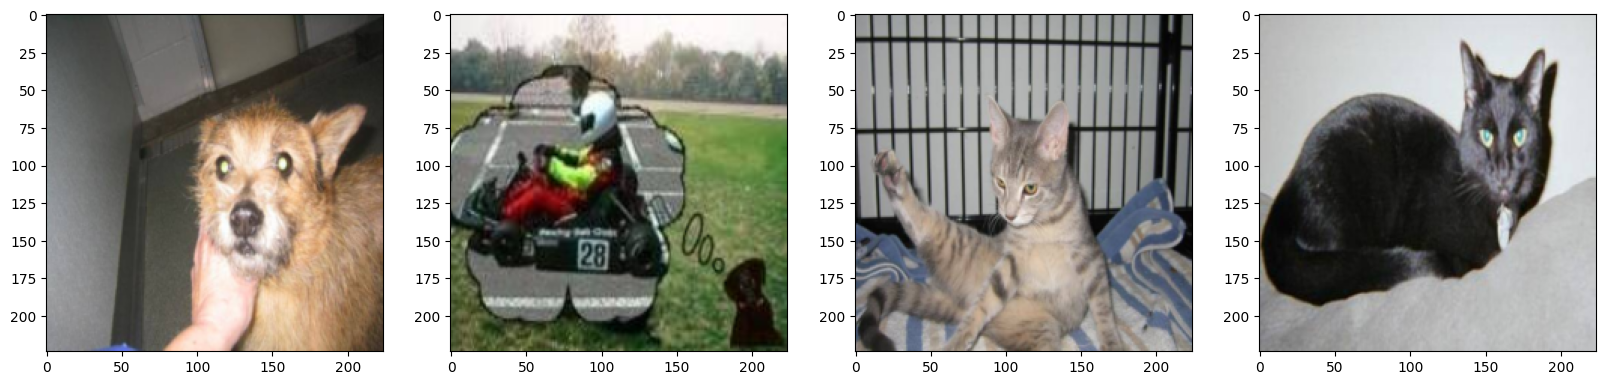

In [ ]:
fig,axs = plt.subplots(1,4, figsize=(20, 10))

axs[0].imshow(im)
axs[1].imshow(im2)
axs[2].imshow(im3)
axs[3].imshow(im4)

# RESNET MODEL

## Fetch pre-trained model weights

In [ ]:
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import resnet18




## Freeze weights and add sigmoidal output layer

In [ ]:
weights = ResNet18_Weights.DEFAULT
resnet_pll = resnet18(weights=weights)
for idx,child in enumerate(resnet_pll.children()):
  if idx == 9:
    print(f'last layer: {child}')
  else:
    for param in child.parameters():
      param.requires_grad = False
resnet_pll.fc = nn.Sequential(nn.Linear(in_features=512, out_features=1,bias=True),nn.Sigmoid())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


last layer: Linear(in_features=512, out_features=1000, bias=True)


## FINE-TUNE ON CAT/DOG IMAGES


In [ ]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Params
LEARNING_RATE = 1e-4

# Initialize
resnet_pll.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet_pll.parameters(), lr=LEARNING_RATE)



# Define training loop
def train_one_epoch():
    running_loss = 0.0
    train_items = 0
    train_correct = 0

    for i, data in enumerate(trainloader):
        X = data[0].float()
        y = data[1].unsqueeze(1).float()
        X, y = X.to(device), y.to(device)
        preds = resnet_pll(X).float()
        loss = criterion(preds, y.float())
        running_loss +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/(i+1)

    return(train_loss)

# Define testing loop
def validate_one_epoch():
    running_test_loss = 0.0
    test_items = 0
    correct = 0
    with torch.no_grad():
        for i, vdata in enumerate(validationloader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device).unsqueeze(1)
          voutputs = resnet_pll(vinputs).float()
          vloss = criterion(voutputs, vlabels.float())
          running_test_loss += vloss
          test_preds = resnet_pll(vinputs.float())
          correct = torch.sum(torch.round(test_preds) == vlabels)
          test_items += len(vlabels)
    return((running_test_loss/(i+1), correct/len(vlabels)))


cuda:0


In [ ]:
# Train
import time

EPOCHS = 15
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models/resnet18', timestr)
for i in range(EPOCHS):
    training_loss = train_one_epoch()
    val_loss, val_accuracy = validate_one_epoch()
    print(f"Epoch {i} | train loss: {training_loss} | val loss: {val_loss} | validation accuracy: {val_accuracy}")

    model_folder_name = f'epoch_{i:04d}_loss_{val_loss:.8f}'
    if not os.path.exists(os.path.join(model_dir, model_folder_name)):
      os.makedirs(os.path.join(model_dir, model_folder_name))
    torch.save(resnet_pll.state_dict(), os.path.join(model_dir, model_folder_name, 'model_state_dict.pth'))

Epoch 0 | train loss: 0.2535324234366417 | val loss: 0.2120652049779892 | validation accuracy: 1.0
Epoch 1 | train loss: 0.1783962531387806 | val loss: 0.1668635755777359 | validation accuracy: 0.875
Epoch 2 | train loss: 0.14617951580882071 | val loss: 0.14067089557647705 | validation accuracy: 0.9375
Epoch 3 | train loss: 0.12643927094340324 | val loss: 0.13202761113643646 | validation accuracy: 1.0
Epoch 4 | train loss: 0.11476481653749943 | val loss: 0.11883489042520523 | validation accuracy: 1.0
Epoch 5 | train loss: 0.10627362820506096 | val loss: 0.11195088922977448 | validation accuracy: 0.9375
Epoch 6 | train loss: 0.1006253930926323 | val loss: 0.10811477154493332 | validation accuracy: 0.9375
Epoch 7 | train loss: 0.09658679544180632 | val loss: 0.09744612127542496 | validation accuracy: 0.9375
Epoch 8 | train loss: 0.09039564384520053 | val loss: 0.09710599482059479 | validation accuracy: 0.9375
Epoch 9 | train loss: 0.08896827143430709 | val loss: 0.09047705680131912 | val

In [ ]:
def load_re_trained_resnet(path_to_model_dict):
  weights = ResNet18_Weights.DEFAULT
  model_to_test = resnet18(weights=weights)
  for idx,child in enumerate(model_to_test.children()):
    if idx == 9:
      print(f'last layer: {child}')
    else:
      for param in child.parameters():
        param.requires_grad = False
  model_to_test.fc = nn.Sequential(nn.Linear(in_features=512, out_features=1,bias=True),nn.Sigmoid())

  model_to_test.load_state_dict(torch.load(path_to_model_dict))
  return(model_to_test)


last layer: Linear(in_features=512, out_features=1000, bias=True)
FINAL TEST ACCURACY: 97.301136%


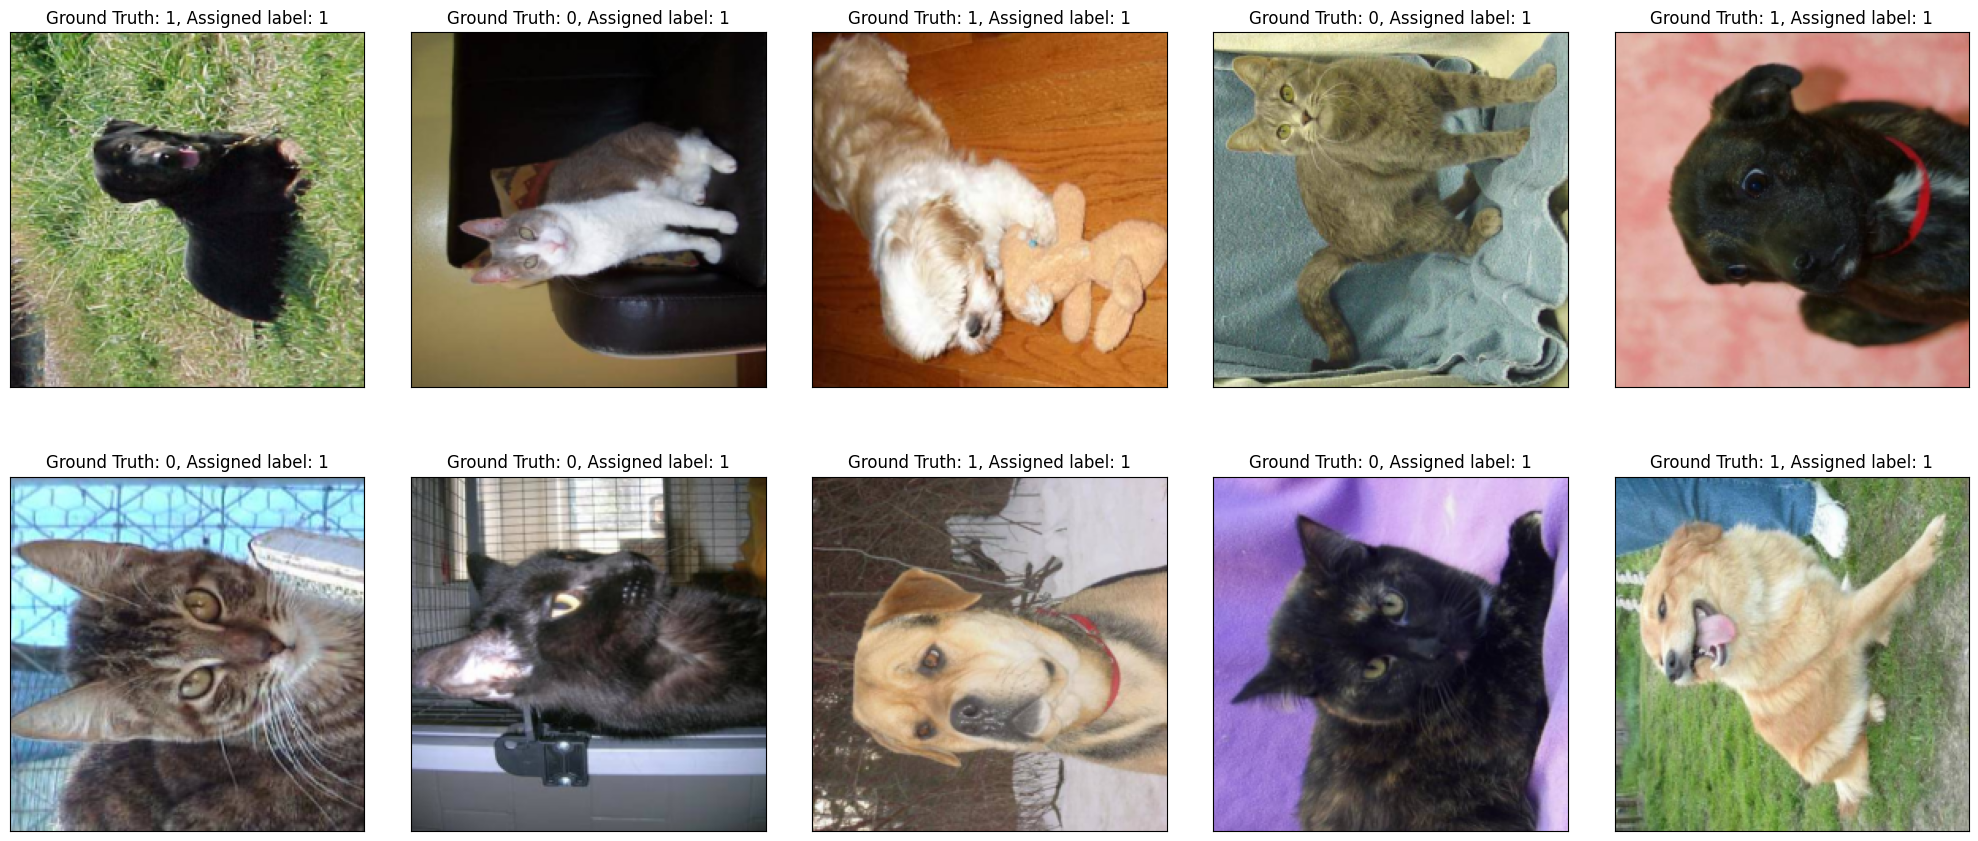

In [ ]:
def inference(model, im_tensor):
  return(int(torch.round(model(im_tensor.unsqueeze(0).to(device))).cpu().item()))

current_model = load_re_trained_resnet('/content/models/resnet18/2023-11-14_02-24-39/epoch_0014_loss_0.08468343/model_state_dict.pth').to(device)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
n = 0
correct = 0
for idx, data in enumerate(testloader):
  correct += torch.sum(torch.round(current_model(data[0].to(device))).cpu().flatten() == data[1].unsqueeze(1).flatten()).item()
  n += len(data[1])
  if idx == 10:
    break
  fig.tight_layout()
  axs[int(idx/5),idx%5].imshow(data[0][0].transpose(0,2))
  axs[int(idx/5),idx%5].set_title(f"Ground Truth: {data[1][0]}, Assigned label: {inference(current_model, data[0][0])}")
  axs[int(idx/5),idx%5].set_xticks([])
  axs[int(idx/5),idx%5].set_yticks([])

print(f'FINAL TEST ACCURACY: {correct/n*100:2f}%')

##Unfreeze and keep fine tuning

In [ ]:
#unfreeze
current_model = load_re_trained_resnet('/content/models/resnet18/2023-11-14_02-24-39/epoch_0014_loss_0.08468343/model_state_dict.pth').to(device)
for idx,child in enumerate(current_model.children()):
  for param in child.parameters():
    param.requires_grad = True


In [ ]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Params
LEARNING_RATE = 1e-4

# Initialize
current_model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(current_model.parameters(), lr=LEARNING_RATE)



# Define training loop
def train_one_epoch():
    running_loss = 0.0
    train_items = 0
    train_correct = 0

    for i, data in enumerate(trainloader):
        X = data[0].float()
        y = data[1].unsqueeze(1).float()
        X, y = X.to(device), y.to(device)
        preds = current_model(X).float()
        loss = criterion(preds, y.float())
        running_loss +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/(i+1)

    return(train_loss)

# Define testing loop
def validate_one_epoch():
    running_test_loss = 0.0
    test_items = 0
    correct = 0
    with torch.no_grad():
        for i, vdata in enumerate(validationloader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device).unsqueeze(1)
          voutputs = current_model(vinputs).float()
          vloss = criterion(voutputs, vlabels.float())
          running_test_loss += vloss
          test_preds = current_model(vinputs.float())
          correct = torch.sum(torch.round(test_preds) == vlabels)
          test_items += len(vlabels)
    return((running_test_loss/(i+1), correct/len(vlabels)))


# EFFICIENTNET MODEL

## Fetch pre-trained model weights

In [ ]:
from torchvision.models.efficientnet import EfficientNet_V2_S_Weights
from torchvision.models import efficientnet_v2_s

## Freeze weights and add sigmoidal output layer

In [ ]:
weights = EfficientNet_V2_S_Weights.DEFAULT
efficientnet = efficientnet_v2_s(weights=weights)
for idx,child in enumerate(efficientnet.children()):
  if idx == 2:
    print(f'last layer: {child}')
    child[1] = nn.Sequential(nn.Linear(in_features=1280, out_features=1,bias=True),nn.Sigmoid())
  else:
    for param in child.parameters():
      param.requires_grad = False
efficientnet

## FINE-TUNE ON CAT/DOG IMAGES


In [ ]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Params
LEARNING_RATE = 1e-4

# Initialize
efficientnet.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=LEARNING_RATE)



# Define training loop
def train_one_epoch():
    running_loss = 0.0
    train_items = 0
    train_correct = 0

    for i, data in enumerate(trainloader):
        X = data[0].float()
        y = data[1].unsqueeze(1).float()
        X, y = X.to(device), y.to(device)
        preds = efficientnet(X).float()
        loss = criterion(preds, y.float())
        running_loss +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/(i+1)

    return(train_loss)

# Define testing loop
def validate_one_epoch():
    running_test_loss = 0.0
    test_items = 0
    correct = 0
    with torch.no_grad():
        for i, vdata in enumerate(validationloader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device).unsqueeze(1)
          voutputs = efficientnet(vinputs).float()
          vloss = criterion(voutputs, vlabels.float())
          running_test_loss += vloss
          test_preds = efficientnet(vinputs.float())
          correct = torch.sum(torch.round(test_preds) == vlabels)
          test_items += len(vlabels)
    return((running_test_loss/(i+1), correct/len(vlabels)))


cuda:0


In [ ]:
# Train
import time

EPOCHS = 15
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models/efficientnet', timestr)
for i in range(EPOCHS):
    training_loss = train_one_epoch()
    val_loss, val_accuracy = validate_one_epoch()
    print(f"Epoch {i} | train loss: {training_loss} | val loss: {val_loss} | validation accuracy: {val_accuracy}")

    model_folder_name = f'epoch_{i:04d}_loss_{val_loss:.8f}'
    if not os.path.exists(os.path.join(model_dir, model_folder_name)):
      os.makedirs(os.path.join(model_dir, model_folder_name))
    torch.save(efficientnet.state_dict(), os.path.join(model_dir, model_folder_name, 'model_state_dict.pth'))

Epoch 0 | train loss: 0.46688401079177855 | val loss: 0.3419229984283447 | validation accuracy: 1.0
Epoch 1 | train loss: 0.2793386399745941 | val loss: 0.24187316000461578 | validation accuracy: 0.9375
Epoch 2 | train loss: 0.21221430480480194 | val loss: 0.2019023895263672 | validation accuracy: 0.9375
Epoch 3 | train loss: 0.17662871608138084 | val loss: 0.1698000133037567 | validation accuracy: 0.875
Epoch 4 | train loss: 0.1571299035847187 | val loss: 0.16322647035121918 | validation accuracy: 0.875
Epoch 5 | train loss: 0.1403170810341835 | val loss: 0.13903267681598663 | validation accuracy: 1.0
Epoch 6 | train loss: 0.13227913242578507 | val loss: 0.13393455743789673 | validation accuracy: 0.9375
Epoch 7 | train loss: 0.1263686065375805 | val loss: 0.12612305581569672 | validation accuracy: 0.875
Epoch 8 | train loss: 0.11811727049946785 | val loss: 0.1343192458152771 | validation accuracy: 0.8125
Epoch 9 | train loss: 0.11468913866579533 | val loss: 0.114458829164505 | validat

In [ ]:
def load_re_trained_efficientnet(path_to_model_dict):
  weights = EfficientNet_V2_S_Weights.DEFAULT
  model_to_test = efficientnet_v2_s(weights=weights)
  for idx,child in enumerate(model_to_test.children()):
    if idx == 2:
      child[1] = nn.Sequential(nn.Linear(in_features=1280, out_features=1,bias=True),nn.Sigmoid())
    else:
      for param in child.parameters():
        param.requires_grad = False
  model_to_test.load_state_dict(torch.load(path_to_model_dict))
  return(model_to_test)


FINAL TEST ACCURACY: 95.738636%


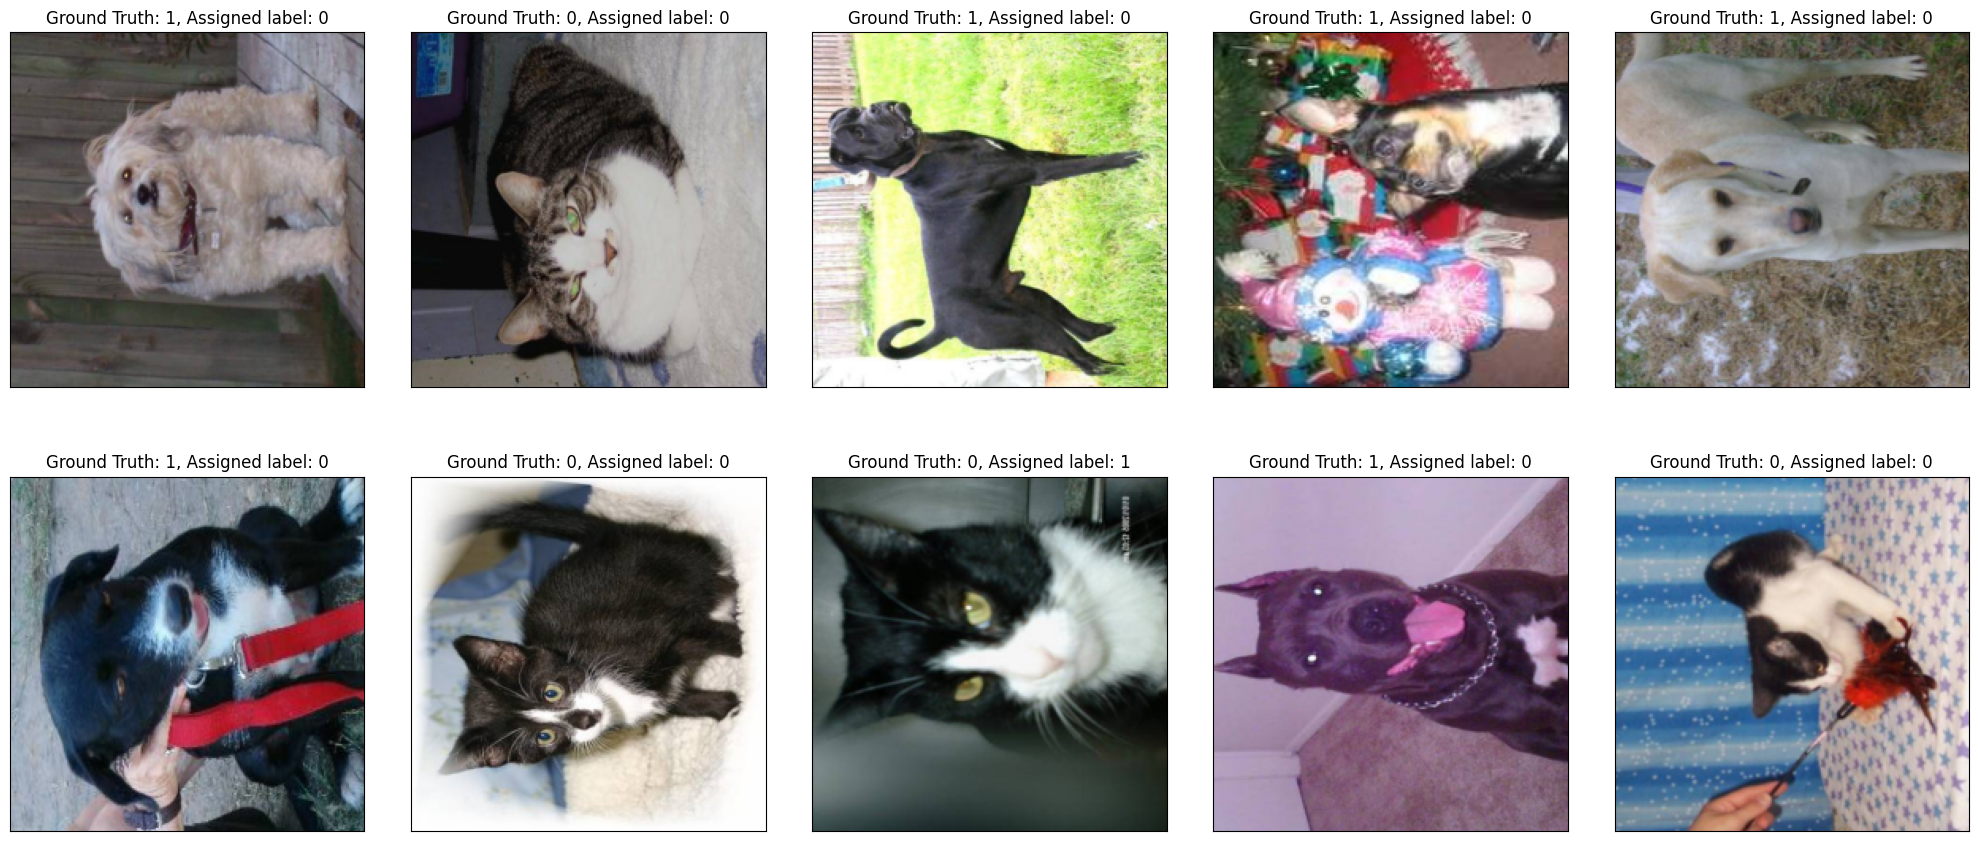

In [ ]:
def inference(model, im_tensor):
  return(int(torch.round(model(im_tensor.unsqueeze(0).to(device))).cpu().item()))

current_model = load_re_trained_efficientnet('/content/models/efficientnet/2023-11-14_03-04-07/epoch_0012_loss_0.10960241/model_state_dict.pth').to(device)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
n = 0
correct = 0
for idx, data in enumerate(testloader):
  correct += torch.sum(torch.round(current_model(data[0].to(device))).cpu().flatten() == data[1].unsqueeze(1).flatten()).item()
  n += len(data[1])
  if idx == 10:
    break
  fig.tight_layout()
  axs[int(idx/5),idx%5].imshow(data[0][0].transpose(0,2))
  axs[int(idx/5),idx%5].set_title(f"Ground Truth: {data[1][0]}, Assigned label: {inference(current_model, data[0][0])}")
  axs[int(idx/5),idx%5].set_xticks([])
  axs[int(idx/5),idx%5].set_yticks([])

print(f'FINAL TEST ACCURACY: {correct/n*100:2f}%')

# ViT

##SETUP and IMPORTS

In [ ]:
!pip install datasets transformers
!pip install accelerate -U
!pip install wandb -qq

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import datasets as ds

##Utilities

In [ ]:
def transform(example_batch):

    inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

##Initialize model and dataloaders

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

train_dataset = ds.load_dataset("imagefolder", data_dir='/content/train',split=None)
test_dataset = ds.load_dataset("imagefolder", data_dir='/content/test',split=None)
validation_dataset = ds.load_dataset("imagefolder", data_dir='/content/validation',split=None)

Resolving data files:   0%|          | 0/16000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
proc_train = train_dataset.with_transform(transform)
proc_test = test_dataset.with_transform(transform)
proc_val = validation_dataset.with_transform(transform)

##Train

In [ ]:
metric = ds.load_metric("accuracy")

In [ ]:
labels = train_dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
  output_dir="./vit-base-catdog",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='wandb',
  load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=proc_train["train"],
    eval_dataset=proc_val["train"],
    tokenizer=processor,
)


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 4618882513GF
  train_loss               =       0.0394
  train_runtime            =   0:50:41.71
  train_samples_per_second =       21.041
  train_steps_per_second   =        1.315


##Test

In [ ]:
metrics = trainer.evaluate(proc_test['train'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

***** test metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.988
  eval_loss               =      0.055
  eval_runtime            = 0:00:38.97
  eval_samples_per_second =     51.309
  eval_steps_per_second   =      6.414
